<a href="https://colab.research.google.com/github/isurunuwanthilaka/ml-mnist/blob/master/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
!pip install kaggle
!mkdir /root/.kaggle

!echo '{"username":"isurunuwanthilaka","key":"db2148ff93a08f45957b3b1ef11040fe"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!mkdir /content
!kaggle config path -p /content
!kaggle competitions download -c digit-recognizer

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/content’: File exists
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#loading data
train= pd.read_csv('./train.csv')
test= pd.read_csv('./test.csv')

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.998):
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [0]:
#type assertion and extraction
train = train.astype('int64')
test = test.astype('int64')
ytrain = train['label']
xtrain = train.drop('label',axis = 1)
dim = 28

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64
4200.0 237.08929400825616


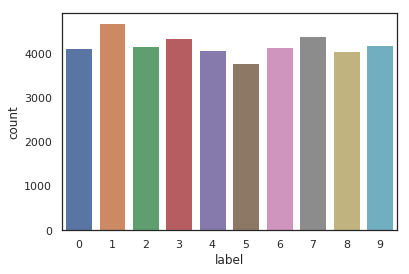

In [37]:
#mean and std of data
sns.set(style='white', context='notebook', palette='deep')
sns.countplot(ytrain)

vals_class = ytrain.value_counts()
print(vals_class)

cls_mean = np.mean(vals_class)
cls_std = np.std(vals_class,ddof=1)
print(cls_mean,cls_std)

In [38]:
#checking null
def check_nan(df):
    print(df.isnull().any().describe())
    print("There are missing values" if df.isnull().any().any() else "There are no missing values")

    if df.isnull().any().any():
        print(df.isnull().sum(axis=0))
        
    print()
        
check_nan(xtrain)
check_nan(test)

count       784
unique        1
top       False
freq        784
dtype: object
There are no missing values

count       784
unique        1
top       False
freq        784
dtype: object
There are no missing values



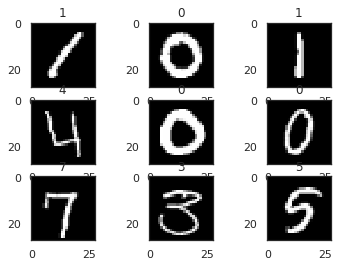

In [39]:
#data visualizing
ntrain = xtrain.shape[0]
xtrain_vis = xtrain.values.reshape(ntrain, dim, dim)

for i in range(0,9): # how many imgs will show from the 3x3 grid
    plt.subplot(330 + (i+1)) # open next subplot
    plt.imshow(xtrain_vis[i], cmap=plt.get_cmap('gray'))
    plt.title(ytrain[i]);

In [0]:
#normalizing
xtrain = xtrain / 255.0
test = test / 255.0

In [41]:
# reshape of image data to (nimg, img_rows, img_cols, 1)
def df_reshape(df):
    print("Previous shape, pixels are in 1D vector:", df.shape)
    df = df.values.reshape(-1, dim, dim, 1) 
    # -1 means the dimension doesn't change, so 42000 in the case of xtrain and 28000 in the case of test
    print("After reshape, pixels are a 28x28x1 3D matrix:", df.shape)
    return df

xtrain = df_reshape(xtrain)
test = df_reshape(test)

Previous shape, pixels are in 1D vector: (42000, 784)
After reshape, pixels are a 28x28x1 3D matrix: (42000, 28, 28, 1)
Previous shape, pixels are in 1D vector: (28000, 784)
After reshape, pixels are a 28x28x1 3D matrix: (28000, 28, 28, 1)


In [42]:
print(type(ytrain))
# number of classes, in this case 10
nclasses = ytrain.max() - ytrain.min() + 1

print("Shape of ytrain before: ", ytrain.shape)

ytrain = tf.keras.utils.to_categorical(ytrain, num_classes = nclasses)

print("Shape of ytrain after: ", ytrain.shape) # (42000, 10), also numpy.ndarray type
print(type(ytrain))

<class 'pandas.core.series.Series'>
Shape of ytrain before:  (42000,)
Shape of ytrain after:  (42000, 10)
<class 'numpy.ndarray'>


In [43]:
from sklearn.model_selection import train_test_split

split_pct = 0.2

# Split the train and the validation set
xtrain, xval, ytrain, yval = train_test_split(xtrain,
                                              ytrain, 
                                              test_size=split_pct,
                                              shuffle=True,
                                              stratify=ytrain
                                             )

print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(33600, 28, 28, 1) (33600, 10) (8400, 28, 28, 1) (8400, 10)


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 64)          51264     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 64)          102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 64)         

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=30,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

datagen.fit(xtrain)

In [0]:
epochs = 15
batch_size = 64

In [51]:
history = model.fit_generator(datagen.flow(xtrain,ytrain, batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(xval,yval),
                              verbose=1, 
                              steps_per_epoch=xtrain.shape[0] // batch_size, 
                              callbacks=[lr_reduction])

Epoch 1/15
525/525 [==============================] - 114s 217ms/step - loss: 0.6166 - acc: 0.7979 - val_loss: 0.0831 - val_acc: 0.9736
Epoch 2/15
525/525 [==============================] - 113s 216ms/step - loss: 0.1908 - acc: 0.9434 - val_loss: 0.0683 - val_acc: 0.9815
Epoch 3/15
525/525 [==============================] - 113s 215ms/step - loss: 0.1501 - acc: 0.9560 - val_loss: 0.0522 - val_acc: 0.9842
Epoch 4/15
525/525 [==============================] - 113s 216ms/step - loss: 0.1214 - acc: 0.9638 - val_loss: 0.0494 - val_acc: 0.9858
Epoch 5/15
525/525 [==============================] - 113s 215ms/step - loss: 0.1066 - acc: 0.9691 - val_loss: 0.0568 - val_acc: 0.9852
Epoch 6/15
525/525 [==============================] - 113s 215ms/step - loss: 0.1027 - acc: 0.9706 - val_loss: 0.0530 - val_acc: 0.9850
Epoch 7/15
525/525 [==============================] - 113s 215ms/step - loss: 0.0952 - acc: 0.9728 - val_loss: 0.0347 - val_acc: 0.9893
Epoch 8/15
525/525 [============================

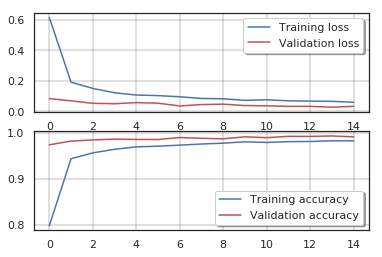

In [52]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

In [53]:
predictions = model.predict_classes(test, verbose=1)

submissions = pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                            "Label": predictions})

submissions.to_csv("submission20190805.csv", index=False, header=True)

28000/28000 [==============================] - 21s 735us/sample
